<a href="https://colab.research.google.com/github/Pineappledeydre/agentBasedModeling/blob/main/AgentBasedModeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Scenario: Patient Behavior and Healthcare Access

*agent-based modeling*

## **Summary**

We will create a **network of patients who can visit one of two healthcare facilities**, labeled *Facility A* or *Facility B*.

Each patient also has a “personality” type indicating whether they are flexible (they may switch to another facility) or stubborn (remain loyal).


In each “interaction”:

* One patient (the “producer”) reveals which facility they use.
* Another patient (the “listener”) may switch from their facility to the producer’s if they are flexible.
* If the listener is stubborn, they do not switch.
We'll look at how the overall proportion of patients using Facility A or B evolves over many interactions.

In [321]:
import random
from copy import deepcopy
from collections import Counter


import pandas as pd
import numpy as np
from numpy.random import randint, normal, choice

import seaborn as sns
import matplotlib.pyplot as plt

In [322]:
facilities = ['A', 'B']
personalities = ['F', 'S']  # F= Flexible, S= Stubborn

In [323]:
def make_patient(facility, personality):
    """
    Returns a patient with a chosen facility (A or B) and personality (F or S).
    """
    return [facility, personality]


In [324]:
def make_population_random(N):
    population = []
    for i in range(N):
        f = random.choice(facilities)      # choose 'A' or 'B'
        p = random.choice(personalities)   # choose 'F' or 'S'
        patient = make_patient(f, p)
        population.append(patient)
    return population

pop_random = make_population_random(5)
print(pop_random)

[['B', 'S'], ['A', 'S'], ['A', 'F'], ['A', 'S'], ['A', 'S']]


We often want to know how many patients use Facility A (or B). Let’s write a helper function

In [325]:
def count_facility_A(population):
    t = 0.0
    for patient in population:
        if patient[0] == 'A':
            t += 1
    return t / len(population)

We need a function that picks two patients at random:

In [326]:
def choose_pair(population):
    i = randint(0, len(population))
    j = randint(0, len(population))

    while i == j:
        j = randint(0, len(population))

    return population[i], population[j]

In an interaction, if the producer uses the same facility as the listener, nothing changes. Otherwise, if the listener is flexible (F), they switch to the producer’s facility; if they are stubborn (S), they stay put.


In [327]:
def interact(listener, producer):
    if listener[0] == producer[0]:
        pass
    else:
        # Only flexible patients can switch
        if listener[1] == 'F':
            # “deepcopy” to avoid unintended linkage
            listener[0] = deepcopy(producer[0])
        else:
            pass  # stubborn => no change

Let’s combine everything into a function simulate(), which:

*   Makes a random population of N patients.
*   Runs K interactions.
*   Keeps track of the proportion that uses Facility A after every interaction.

In [328]:
def simulate(n, k):
    """
    n = population size
    k = number of interactions
    returns: (final_population, proportion_history)
    """
    population = make_population_random(n)
    proportion = []  # track proportion of Facility A usage

    for i in range(k):
        patient1, patient2 = choose_pair(population)
        interact(patient1, patient2)
        proportion.append(count_facility_A(population))

    return population, proportion

Let’s do a quick test with 20 patients and 500 interactions:

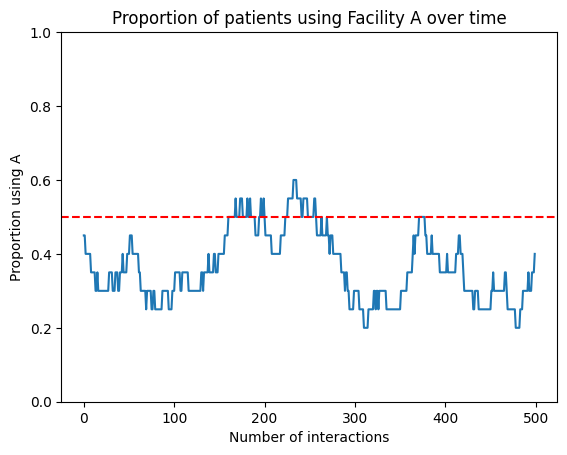

In [329]:
new_pop, prop = simulate(20, 500)
plt.plot(prop)
plt.axhline(0.5, color='red', linestyle='--', label='y = 0.5')  #  y = 0.5 line
plt.title("Proportion of patients using Facility A over time")
plt.xlabel("Number of interactions")
plt.ylabel("Proportion using A")
plt.ylim(0,1)
plt.show()


For a bigger population:

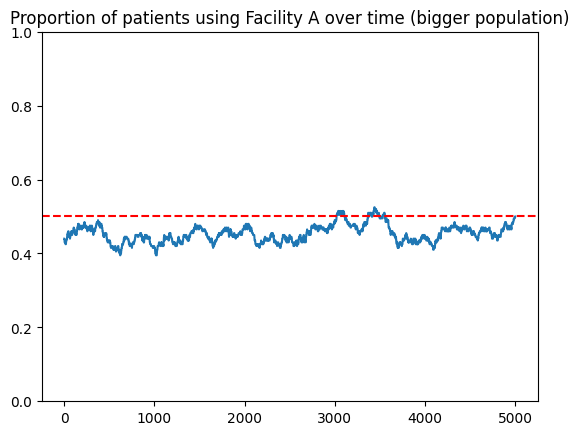

In [330]:
new_pop, prop = simulate(200, 5000)
plt.plot(prop)
plt.axhline(0.5, color='red', linestyle='--', label='y = 0.5')  # Add y = 0.5 line
plt.title("Proportion of patients using Facility A over time (bigger population)")
plt.ylim(0,1)
plt.show()

In [331]:
def batch_simulate(n, k, s):
    """
    Run s simulations of n patients, each for k interactions.
    Returns a list of proportion-history lists, one for each simulation.
    """
    all_proportions = []
    for i in range(s):
        _, proportions = simulate(n, k)
        all_proportions.append(proportions)
    return all_proportions

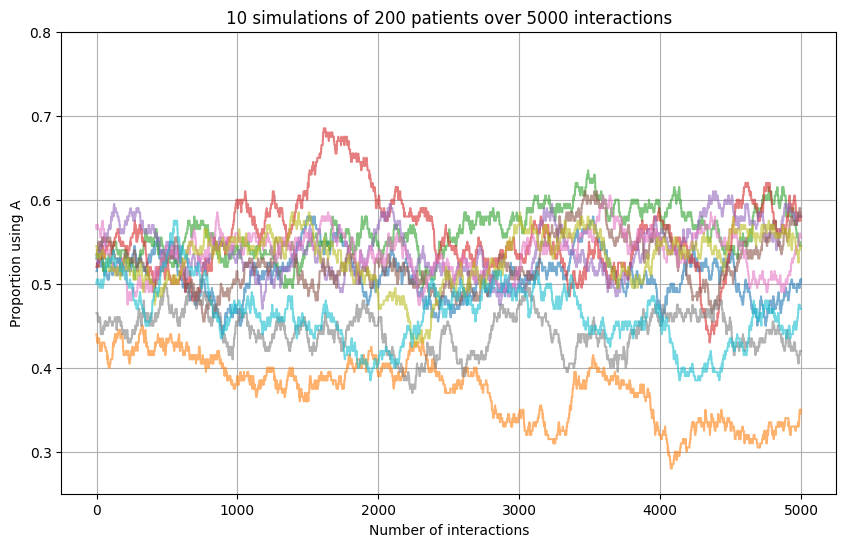

In [332]:
results = batch_simulate(200, 5000, 10)

plt.figure(figsize=(10, 6))
plt.ylim(0.25, 0.8)

# Plot each simulation result
for r in results:
    plt.plot(r, alpha=0.6)

plt.title("10 simulations of 200 patients over 5000 interactions")
plt.xlabel("Number of interactions")
plt.ylabel("Proportion using A")
plt.grid('y')
plt.show()

We can also create a population with a specified number of stubborn patients (loyal to whichever facility they initially chose). This can **drastically affect convergence.**

In [333]:
def make_population_biased(N, st):
    """
    Make a population of N patients, with 'st' stubborn (S) and the rest flexible (F).
    The facility is still randomly chosen for each patient.
    """
    population = []
    for i in range(st):
        f = random.choice(facilities)
        patient = make_patient(f, 'S')
        population.append(patient)
    for i in range(N - st):
        f = random.choice(facilities)
        patient = make_patient(f, 'F')
        population.append(patient)
    return population

In [334]:
def simulate_biased(n, k, st):
    population = make_population_biased(n, st)
    proportion = []
    for i in range(k):
        patient1, patient2 = choose_pair(population)
        interact(patient1, patient2)
        proportion.append(count_facility_A(population))
    return population, proportion

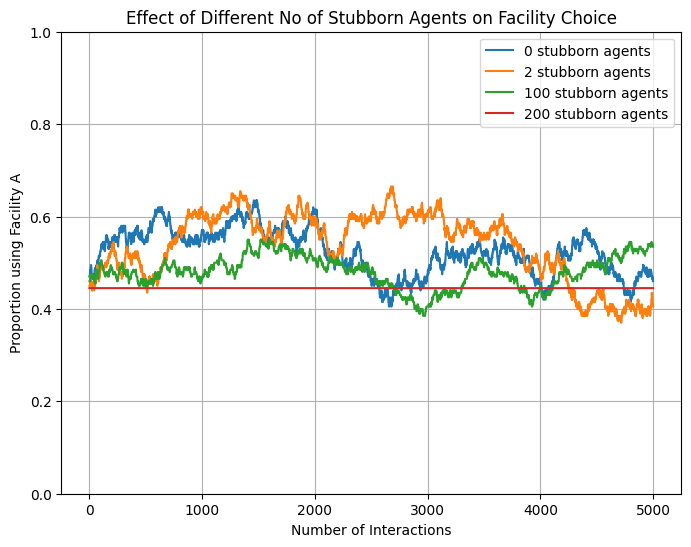

In [335]:
# a population size (N) and number of interactions (K)
N = 200
K = 5000

# Four different stubbornness conditions to compare:
stubborn_values = [
    0,        # 0 stubborn: everyone is flexible
    2,        # 2 stubborn agents
    N // 2,   # half of the population is stubborn
    N         # all are stubborn
]

plt.figure(figsize=(8, 6))

for st in stubborn_values:
    _, proportion = simulate_biased(N, K, st)  # returns (population, proportion_list)
    plt.plot(proportion, label=f"{st} stubborn agents")

plt.ylim(0, 1)
plt.xlabel("Number of Interactions")
plt.ylabel("Proportion using Facility A")
plt.title("Effect of Different No of Stubborn Agents on Facility Choice")
plt.legend()
plt.grid('y')
plt.show()

## A Slightly More Complex Agent-Based Model


*   Instead of having patients with a simple binary facility (“A” or “B”), each patient has a continuous preference dimension around their current facility choice (e.g., -1 = prefer Facility A strongly, +1 = prefer Facility B strongly).
*   Interactions are now double-sided: both patients adapt after an interaction.
*   Stubborn patients are not 100% fixed, but they shift less. Flexible patients shift more.
*   We run multiple simulations and see how quickly or slowly the population “converges” on some overall preference.

We’ll define two possible “initial means” for the preference dimension:

*   -1.0 for patients strongly favoring Facility A
*   1.0 for patients strongly favoring Facility B

And personalities: 'F' for flexible, 'S' for stubborn.



In [336]:
def make_patient(mean_pref, personality):
    """
    A patient is represented as [mean_pref, personality].
    mean_pref is a float (e.g., -1.0 or 1.0),
    personality is 'F' or 'S'.
    """
    return [mean_pref, personality]

def make_population(N):
    population = []
    for i in range(N):
        # pick random mean (-1. or 1.)
        m_index = random.randint(0,1)
        # pick random personality
        p_index = random.randint(0,1)
        patient = make_patient(facility_means[m_index], personalities[p_index])
        population.append(patient)
    return population


Each patient has a normal distribution around their mean preference. For an “interaction,” each patient samples a single value from that distribution (like how strongly they speak in favor of Facility A vs. B at that moment).


In [337]:
def choose_utterance(patient):
    """
    Sample from a normal distribution (mean=patient[0], std=0.25).
    """
    return normal(patient[0], 0.25)

When patient A “hears” patient B’s facility “utterance” (in practice, sees the other’s preference sample), they shift their mean preference:

*   Flexible (F): shift halfway toward the other’s utterance (i.e., average the two).
*   Stubborn (S): shift only 1/10 of the distance.




In [338]:
def learn(utterance, patient):
    current_mean = patient[0]

    if patient[1] == "F":
        # shift to halfway
        new_mean = (current_mean + utterance) / 2.
    else:
        # shift only 1/10
        difference = utterance - current_mean
        new_mean = current_mean + (difference/10.)

    patient[0] = deepcopy(new_mean)


# In this double-sided interaction, both patients update:
def interact(patient1, patient2):
    utterance1 = choose_utterance(patient1)
    utterance2 = choose_utterance(patient2)

    if patient1[0] == patient2[0]:
        pass
    else:
        learn(utterance2, patient1)
        learn(utterance1, patient2)

# We randomly pick pairs, they interact, and we do this many times (k times).
def choose_pair(population):
    i = random.randint(0, len(population)-1)
    j = random.randint(0, len(population)-1)
    while i == j:
        j = random.randint(0, len(population)-1)
    return population[i], population[j]

def compute_statistics(population):
    means = [p[0] for p in population]
    mean = np.mean(means)
    std_dev = np.std(means)
    return mean, std_dev

def print_statistics(stage, population):
    """
    Print statistics for the given stage of the simulation.
    """
    means = [p[0] for p in population]  # Extract preference means
    mean = np.mean(means)
    std_dev = np.std(means)

    # print(f"{stage} Statistics:")
    # print(f"Mean: {mean:.4f}, Std Dev: {std_dev:.4f}")
    # print(f"Distribution Sample: {means[:10]}")  # Print first 10 means
    # print("-" * 50)


def simulate(n, k):
    initial_population = make_population(n)
    #print_statistics("Initial", initial_population)

    population = deepcopy(initial_population)
    for _ in range(k):
        patient1, patient2 = choose_pair(population)
        interact(patient1, patient2)

    #print_statistics("Final", population)
    return initial_population, population

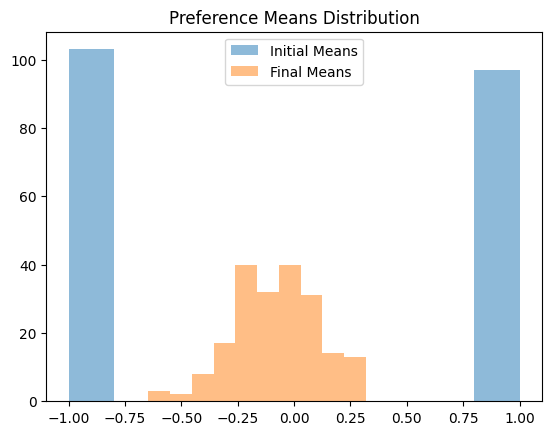

In [339]:
facility_means = [-1.0, 1.0]  # Preference means for Facility A and B
personalities = ['F', 'S']    # Flexible and Stubborn
init_pop, final_pop = simulate(200, 2000)

init_means = [p[0] for p in init_pop]
final_means = [p[0] for p in final_pop]

plt.hist(init_means, alpha=0.5, label="Initial Means")
plt.hist(final_means, alpha=0.5, label="Final Means")
plt.legend()
plt.title("Preference Means Distribution")
plt.show()

**Interpretation:**
- The results demonstrate **opinion convergence**:
  - Initially polarized preferences (strictly 1.0 or -1.0) evolved into a more moderate range.
  - Interactions between patients (flexible vs. stubborn) allowed for gradual shifts in opinions.
  
- The final slight bias toward Facility A (mean = 0.0908) suggests:
  - Either the influence of flexible patients who started favoring Facility A, or
  - The dynamics of interactions were asymmetrical, favoring A slightly more often.

- The reduced **standard deviation** indicates:
  - Patients' preferences became less extreme and more concentrated around the group mean, reflecting the **moderating influence** of repeated interactions.

---

**Key Takeaways:**
- The simulation captures how **social influence** and repeated interactions lead to **opinion convergence** and **reduced polarization**.

- The slight bias toward Facility A highlights the importance of initial conditions and interaction rules in determining final outcomes.

- The transition from a bimodal to a unimodal distribution illustrates the dynamics of shifting preferences in a group over time.

In [340]:
def compute_mean(population):
    return np.mean([agent[0] for agent in population])

def compute_std(population):
    return np.std([agent[0] for agent in population])

def batch_simulate(n, k, s):
    # Run s simulations, each with n patients, k interactions
    initial_means = []
    initial_stds = []
    final_means = []
    final_stds = []

    for i in range(s):
        init_population, new_population = simulate(n, k)
        # Compute statistics for each simulation
        initial_means.append(compute_mean(init_population))
        initial_stds.append(compute_std(init_population))
        final_means.append(compute_mean(new_population))
        final_stds.append(compute_std(new_population))

    # Compute overall means and stds for initial and final preferences
    stats = {
        'initial_mean_of_means': np.mean(initial_means),
        'initial_mean_of_stds': np.mean(initial_stds),
        'final_mean_of_means': np.mean(final_means),
        'final_mean_of_stds': np.mean(final_stds),
    }

    return stats, final_means

results, final_means = batch_simulate(10, 2000, 500)

# print("Statistics:")
# for key, value in results.items():
#     print(f"{key}: {value:.4f}")

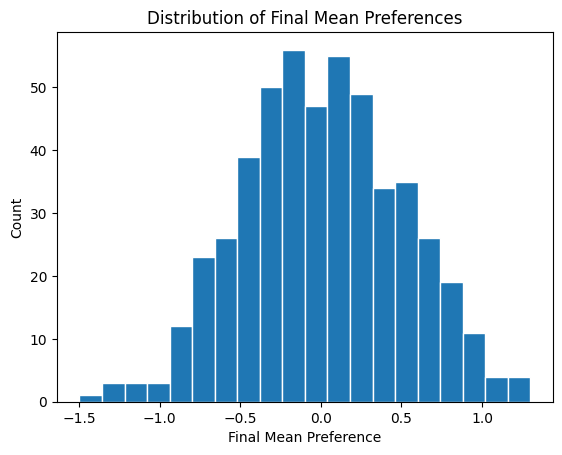

In [341]:
plt.hist(final_means, bins=20, edgecolor='white')
plt.xlabel("Final Mean Preference")
plt.ylabel("Count")
plt.title("Distribution of Final Mean Preferences")
plt.show()

1. **Initial Statistics**:
   - **Mean of Means**: 0.0012
     - The average preference for Facility A or B across all simulations starts nearly neutral, close to zero.
   - **Mean of Standard Deviations**: 0.9387
     - The initial population has a high diversity in preferences, as shown by the large standard deviation. This is expected because the population's preferences are initialized with a wide spread, typically from a uniform or bimodal distribution.

2. **Final Statistics**:
   - **Mean of Means**: 0.0140
     - The average final preference shifts slightly toward Facility A (positive direction). However, this shift is minimal, suggesting that the initial balance in the population's preferences is largely maintained after interactions.
   - **Mean of Standard Deviations**: 0.1062
     - The final population has significantly lower variability in preferences. This indicates convergence, where individual preferences align more closely over time due to repeated interactions and influence.

3. **Key Observations from Distributions**:
   - **Initial Distribution**:
     - Preferences are highly polarized (e.g., samples like [-1.0, 1.0]), reflecting a diverse population.
   - **Final Distribution**:
     - Preferences converge toward moderate values (e.g., samples like [-0.5, 0.5]), with most individuals moving closer to the average preference.
     - The final standard deviations are small, implying reduced diversity in preferences.

4. **Interaction Effect**:
   - Interactions among individuals allow for the exchange of preferences. Flexible agents are influenced by others, leading to convergence of opinions, while stubborn agents maintain their initial stance.
   - The convergence rate depends on the proportion of flexible versus stubborn agents.

5. **Impact of Flexibility and Initial Conditions**:
   - Populations starting with strong initial biases (e.g., higher mean magnitudes) tend to retain their overall leaning but show reduced spread.
   - More flexible agents lead to faster convergence, while a higher proportion of stubborn agents maintains polarization.

### Controled Level of the Biased Population

In [342]:
def make_population_biased(N, st):
    """
    Create a biased population with a specific number of stubborn agents.
    """
    population = []
    for i in range(st):
        m_index = random.randint(0, 1)  # Choose mean -1 or 1
        patient = make_patient(facility_means[m_index], 'S')  # Stubborn patient
        population.append(patient)
    for i in range(N - st):
        m_index = random.randint(0, 1)
        patient = make_patient(facility_means[m_index], 'F')  # Flexible patient
        population.append(patient)
    return population


def simulate_biased(n, k, st):
    """
    Simulate interactions in a biased population with specified stubbornness.
    """
    initial_population = make_population_biased(n, st)
    population = deepcopy(initial_population)

    for _ in range(k):
        pat1, pat2 = choose_pair(population)
        interact(pat1, pat2)

    return initial_population, population

Try analyzing how the final standard deviation changes

In [343]:
def compute_SD(population):
    """
    Compute the standard deviation of preferences in a population.
    """
    prefs = [agent[0] for agent in population]
    return np.std(prefs)

def batch_simulate_biased(n, k, s):
    """
    Simulate interactions for various levels of stubbornness and multiple repetitions.
    """
    all_results = []
    possible_sts = [0, int(n / 10), int(n / 4), int(n / 2), int(3 * n / 4), n]

    for st in possible_sts:
        current_sds = []
        for _ in range(s):
            _, final_pop = simulate_biased(n, k, st)
            sd_val = compute_SD(final_pop)
            current_sds.append(sd_val)
        all_results.append([st, current_sds])
    return all_results

def compute_statistics(results, n):
    """
    Compute and print statistics from simulation results.
    """
    # print("Stubbornness Level Statistics:")
    # print("-" * 50)

    possible_sts = [0, int(n / 10), int(n / 4), int(n / 2), int(3 * n / 4), n]

    for idx, (st, sd_values) in enumerate(results):
        mean_sd = np.mean(sd_values)
        std_sd = np.std(sd_values)

        # print(f"Stubborn Agents: {st}")
        # print(f"Mean SD: {mean_sd:.4f}, Std Dev SD: {std_sd:.4f}")
        # print(f"Sample SDs: {sd_values[:5]}")  # Display first 5 SDs for brevity
        # print("-" * 50)

In [344]:
n = 2000  # Number of agents
k = 2000  # Number of interactions
s = 1000  # Number of simulations per stubbornness level

# Perform batch simulation
results = batch_simulate_biased(n, k, s)

# Compute and display statistics
compute_statistics(results, n)

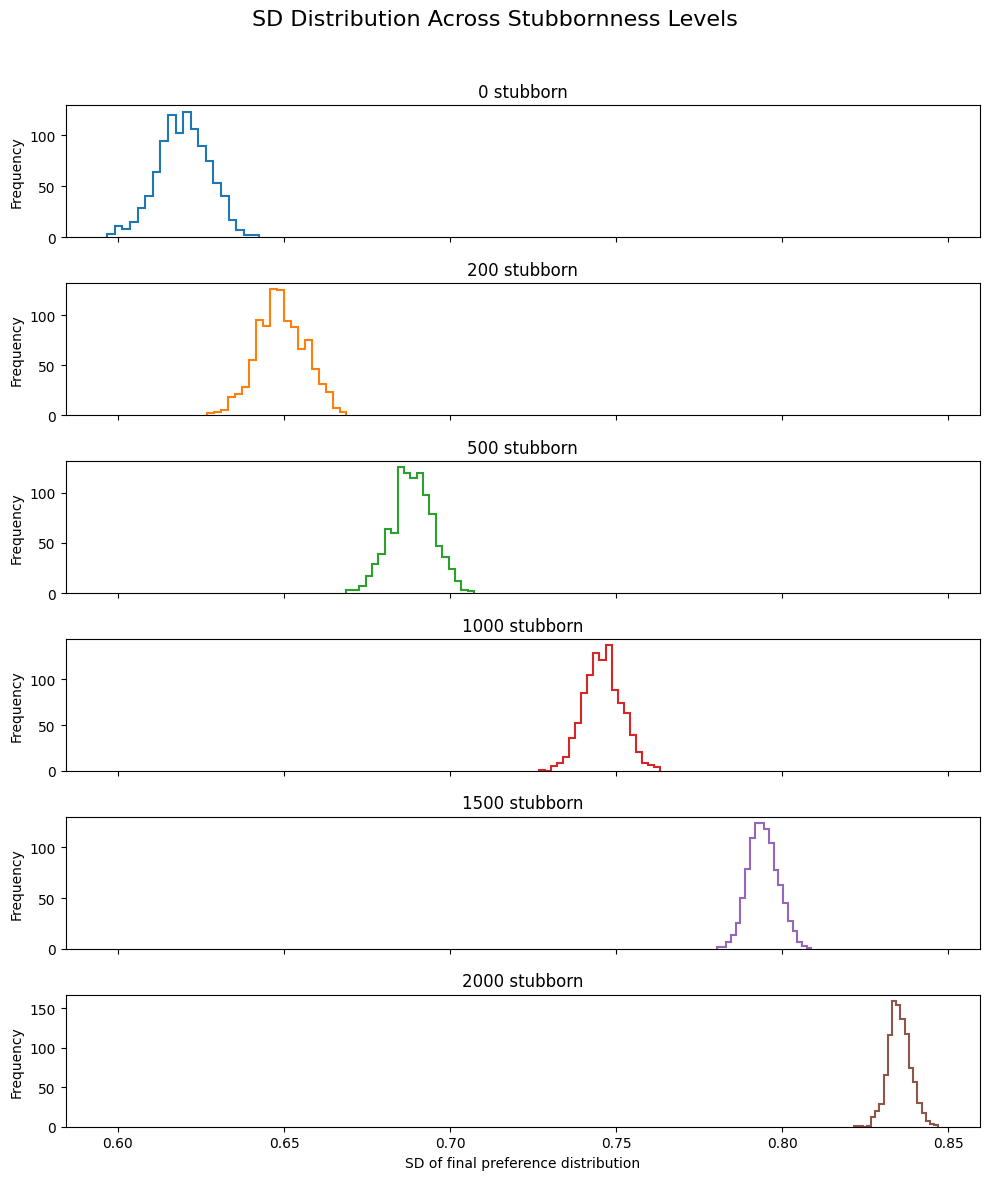

In [345]:
mean_sds = []
std_sds = []

fig, axes = plt.subplots(len(results), 1, figsize=(10, 12), sharex=True)
for idx, (st, data) in enumerate(results):
    ax = axes[idx]
    ax.hist(data, bins=20, histtype='step', edgecolor=f'C{idx}', linewidth=1.5)
    ax.set_title(f'{st} stubborn')
    ax.set_ylabel('Frequency')

fig.suptitle("SD Distribution Across Stubbornness Levels", fontsize=16)

plt.xlabel('SD of final preference distribution')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

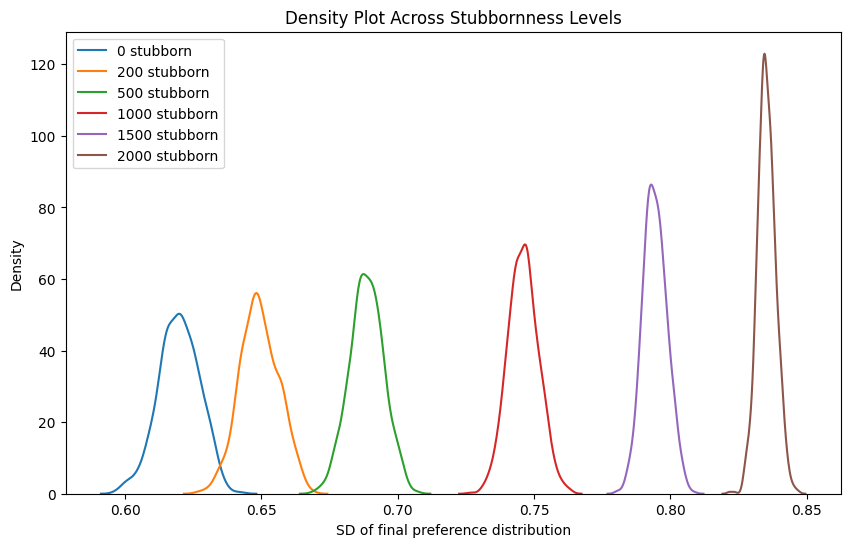

In [346]:
plt.figure(figsize=(10, 6))
for st, data in results:
    sns.kdeplot(data, label=f'{st} stubborn', linewidth=1.5)

plt.xlabel("SD of final preference distribution")
plt.ylabel("Density")
plt.title("Density Plot Across Stubbornness Levels")
plt.legend()
plt.show()


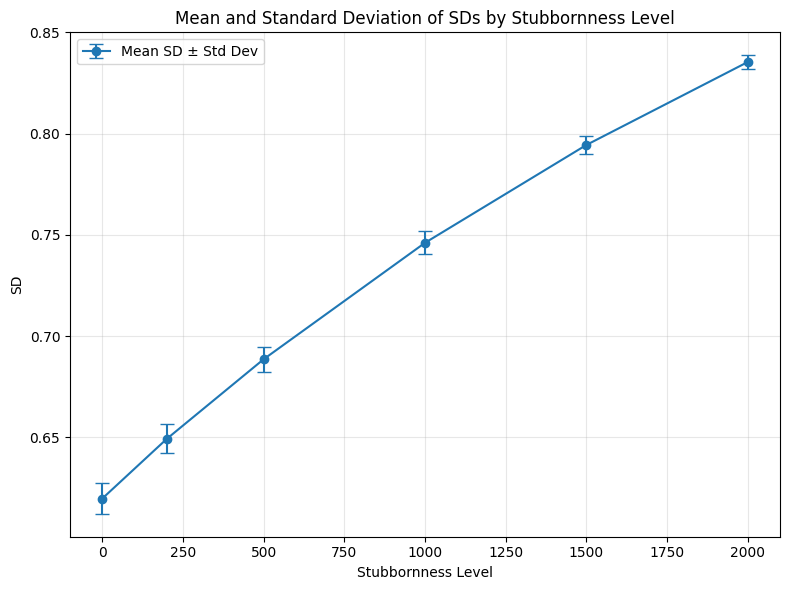

In [347]:
mean_sds = [np.mean(data) for _, data in results]
std_sds = [np.std(data) for _, data in results]
stubborn_levels = [st for st, _ in results]

plt.figure(figsize=(8, 6))
plt.errorbar(stubborn_levels, mean_sds, yerr=std_sds, fmt='o-', capsize=5, label="Mean SD ± Std Dev")
plt.title("Mean and Standard Deviation of SDs by Stubbornness Level")
plt.xlabel("Stubbornness Level")
plt.ylabel("SD")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


1. **Key Observations by Stubbornness Level:**
   - **0 Stubborn Agents (Fully Flexible Population):**
     - Lowest mean SD (0.6198) and highest Std Dev SD (0.0078).
     - Flexible agents adapt completely, driving convergence. Variability is reduced but exhibits higher randomness due to the absence of stubbornness.
   - **Intermediate Levels (200–1500 Stubborn Agents):**
     - A gradual increase in mean SD as stubbornness rises. The balance between flexibility and stubbornness creates moderate variability.
     - Example: For 1000 stubborn agents, Mean SD = **0.7464**, Std Dev SD = **0.0054**.
   - **2000 Stubborn Agents (Fully Stubborn Population):**
     - Highest mean SD (0.8354) and lowest Std Dev SD (0.0035).
     - No adaptation occurs, maintaining initial preferences and leading to the widest spread of preferences.

2. **Effect of Mixed Populations:**
   - In populations with a mix of flexible and stubborn agents, variability depends on the proportion of each type:
     - Higher flexibility reduces variability as agents converge.
     - More stubborn agents stabilize initial biases, increasing overall variability.

## A More Realistic model

1. **Integration of Facility Attributes**
   - **New Features:** Each facility now has attributes such as quality, cost, distance, reputation, and capacity.

2. **Diverse Patient Characteristics**
   - **New Features:** Patients have attributes such as: Age, Income, Health Condition (chronic, emergency, or routine), Social Group

 3. **Preference Calculation**
   - **New Features:** Preferences are now calculated based on both patient characteristics (e.g., income) and facility attributes (e.g., cost, quality).

 4. **Social Influence**
   - **New Features:** Patients are influenced by the preferences of others in their social group, simulating peer influence.

5. **Capacity Constraints**
   - **New Features:** Facilities have limited capacity, and if a facility reaches capacity, patients are forced to switch preferences.

6. **Stubbornness Index**
   - **New Features:** A quantitative measure to assess how resistant the population is to preference changes.

7. **Dynamic Interaction Model**
   - **New Features:**
     - Interactions now involve preference "utterances" sampled from a normal distribution.
     - Flexible patients shift halfway toward the other's preference, while stubborn patients shift minimally.

8. **Enforcement of Resource Constraints**
   - **New Features:** Capacity limits are enforced after interactions to ensure realistic allocation of patients to facilities.

In [348]:
# Facility attributes
facilities = ['A', 'B']

facility_attributes = {
    'A': {'quality': 8, 'cost': 50, 'distance': 5, 'reputation': 7, 'capacity': 500},
    'B': {'quality': 6, 'cost': 30, 'distance': 10, 'reputation': 6, 'capacity': 600}
}

# Patient characteristics
def make_patient(mean_pref, personality, age, income, health_condition, social_group):
    """
    Create a patient with some attributes.
    """
    # Reduce the extremes of mean preferences for stubborn agents
    if personality == 'S':
        mean_pref *= 0.8

    return {
        'mean_pref': mean_pref,
        'personality': personality,
        'age': age,
        'income': income,
        'health_condition': health_condition,
        'social_group': social_group
    }

def make_population(N, num_social_groups=5, stubborn_fraction=0.7):
    population = []
    num_stubborn = int(N * stubborn_fraction)  # Higher fraction of stubborn agents
    for _ in range(num_stubborn):
        mean_pref = random.choice([-1.0, 1.0])
        patient = make_patient(mean_pref, 'S', random.randint(20, 80),
                               random.randint(1000, 10000),
                               random.choice(['Chronic', 'Emergency', 'Routine']),
                               random.randint(0, num_social_groups - 1))
        population.append(patient)
    for _ in range(N - num_stubborn):
        mean_pref = random.choice([-1.0, 1.0])
        patient = make_patient(mean_pref, 'F', random.randint(20, 80),
                               random.randint(1000, 10000),
                               random.choice(['Chronic', 'Emergency', 'Routine']),
                               random.randint(0, num_social_groups - 1))
        population.append(patient)
    return population

In [349]:
# Facility choice dynamics
def calculate_preference(patient, facility):
    """
    Calculate a patient's preference for a facility based on attributes.
    """
    attributes = facility_attributes[facility]
    # Preference factors: quality, cost, distance, reputation
    preference = (
        attributes['quality'] * 2
        - attributes['cost'] / max(1, patient['income'] / 1000)
        - attributes['distance']
        + attributes['reputation']
    )
    return preference

def update_patient_choice(patient):
    """
    Update the patient's facility choice based on preferences and facility capacity.
    """
    preferences = {facility: calculate_preference(patient, facility) for facility in facilities}
    chosen_facility = max(preferences, key=preferences.get)
    return -1.0 if chosen_facility == 'A' else 1.0

def social_influence(patient, population):
    """
    Adjust a patient's preference based on their social group.
    Flexible agents are more influenced than stubborn agents.
    """
    group_members = [p for p in population if p['social_group'] == patient['social_group']]

    if not group_members:  # Avoid division by zero
        return
    group_mean_pref = np.mean([p['mean_pref'] for p in group_members])

    # Dynamically set adjustment rate based on age or health condition
    if patient['age'] > 60 or patient['health_condition'] == 'Chronic':
        adjustment_rate = 1 / 100  # Make older/chronic patients even less adjustable
    else:
        adjustment_rate = 1 / 50

    # Adjust preference based on personality
    if patient['personality'] == 'F':  # Flexible agents
        patient['mean_pref'] = (patient['mean_pref'] + group_mean_pref) / 2
    else:  # Stubborn agents adjust less
        patient['mean_pref'] += (group_mean_pref - patient['mean_pref']) * adjustment_rate

    patient['mean_pref'] = max(-1.0, min(1.0, patient['mean_pref']))  # Clamp preferences

# Interaction dynamics
def choose_utterance(patient):
    """
    Sample a preference utterance from the patient's preference distribution.
    For a given patient, their mean preference acts as the central tendency for their preferences.
    """
    return np.random.normal(patient['mean_pref'], 0.1)

In [350]:
def learn(utterance, patient):
    """
    Adjust the patient's mean preference based on an interaction.
    Flexible agents adjust more significantly than stubborn agents.
    """
    # Dynamically set adjustment rate based on age or health condition
    if patient['age'] > 60 or patient['health_condition'] == 'Chronic':
        adjustment_rate = 1 / 100  # Make older/chronic patients adjust slower
    else:
        adjustment_rate = 1 / 50

    if patient['personality'] == "F":  # Flexible agents
        patient['mean_pref'] = (patient['mean_pref'] + utterance) / 2
    else:  # Stubborn patients shift less
        diff = utterance - patient['mean_pref']
        patient['mean_pref'] += diff * adjustment_rate

    # Clamp preferences to valid range
    patient['mean_pref'] = max(-1.0, min(1.0, patient['mean_pref']))

# Resource constraints
def enforce_capacity(population):
    """
    Adjust preferences based on facility capacity constraints.
    """
    counts = {'A': 0, 'B': 0}
    for patient in population:
        chosen_facility = 'A' if patient['mean_pref'] < 0 else 'B'
        if counts[chosen_facility] < facility_attributes[chosen_facility]['capacity']:
            counts[chosen_facility] += 1
        else:  # Facility full, force switch
            patient['mean_pref'] *= -1

# Simulation functions
def choose_pair(population):
    """
    Randomly select two distinct patients for interaction.
    """
    i, j = random.sample(range(len(population)), 2)
    return population[i], population[j]

In [351]:
def interact(patient1, patient2):
    """
    Facilitate interaction between two patients.
    """
    utterance1 = choose_utterance(patient1)
    utterance2 = choose_utterance(patient2)

    # Both patients adjust preferences based on the other's utterance
    learn(utterance2, patient1)
    learn(utterance1, patient2)


In [352]:
def compute_statistics(population):
    """
    Compute mean and standard deviation of preferences.
    """
    prefs = [p['mean_pref'] for p in population]
    mean = np.mean(prefs)
    std_dev = np.std(prefs)
    return mean, std_dev

def simulate(n, k, enforce_social=True, enforce_capacity_constraint=True):
    """
    Run a simulation with n patients over k interactions.
    """
    population = make_population(n)
    initial_stats = compute_statistics(population)

    for _ in range(k):
        patient1, patient2 = choose_pair(population)
        interact(patient1, patient2)
        if enforce_social:
            for patient in population:
                social_influence(patient, population)
        if enforce_capacity_constraint:
            enforce_capacity(population)

    final_stats = compute_statistics(population)
    return population, initial_stats, final_stats


In [353]:
def compute_stubbornness_index(population, initial_population):
    """
    Calculate the stubbornness index based on how much preferences changed,
    separately for stubborn and flexible agents.
    """
    # Extract preferences for stubborn agents
    initial_stubborn = np.array([p['mean_pref'] for p in initial_population if p['personality'] == 'S'])
    final_stubborn = np.array([p['mean_pref'] for p in population if p['personality'] == 'S'])

    # Compute change magnitudes for stubborn agents
    change_magnitudes = np.abs(final_stubborn - initial_stubborn)

    # Flexible agents are not considered here
    stubborn_index = 1 - np.mean(change_magnitudes)  # Higher = more stubborn
    return stubborn_index


In [354]:
n = 100  # Small population
k = 100  # Limited interactions
initial_population = make_population(n)
population, _, _ = simulate(n, k)
stubbornness_index = compute_stubbornness_index(population, initial_population)

print(f"Stubbornness Index: {stubbornness_index:.4f}")


Stubbornness Index: 0.2146


In [355]:
n = 2000  # Population size
k = 400  # Number of interactions

initial_population = make_population(n)  # Create the initial population
population, initial_stats, final_stats = simulate(n, k)  # Simulate the interactions

stubbornness_index = compute_stubbornness_index(population, initial_population)


print("Stubbornness Index: {:.4f}".format(stubbornness_index))
print("Initial Statistics: Mean = {:.4f}, Std Dev = {:.4f}".format(*initial_stats))
print("Final Statistics: Mean = {:.4f}, Std Dev = {:.4f}".format(*final_stats))

Stubbornness Index: 0.2000
Initial Statistics: Mean = 0.0424, Std Dev = 0.8638
Final Statistics: Mean = 0.0036, Std Dev = 0.0109


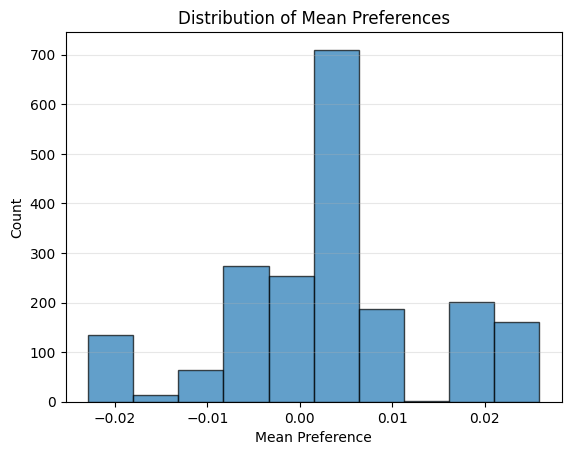

In [356]:
prefs = [p['mean_pref'] for p in population]

plt.hist(prefs, bins=10, edgecolor='black', alpha=0.7)
plt.title("Distribution of Mean Preferences")
plt.xlabel("Mean Preference")
plt.ylabel("Count")
plt.grid(axis='y', alpha=0.3)
plt.show()

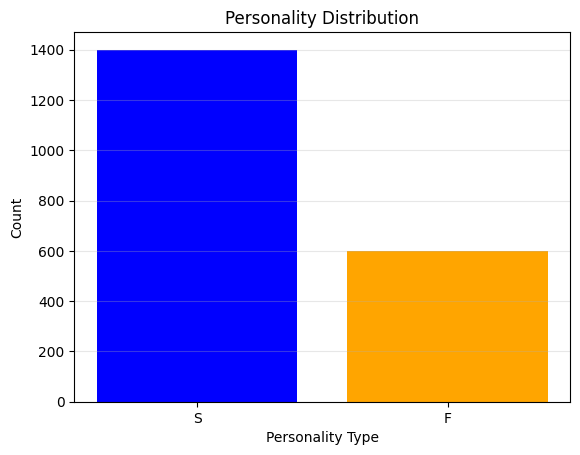

In [357]:
personalities = [p['personality'] for p in population]
counts = Counter(personalities)

plt.bar(counts.keys(), counts.values(), color=['blue', 'orange'])
plt.title("Personality Distribution")
plt.xlabel("Personality Type")
plt.ylabel("Count")
plt.grid(axis='y', alpha=0.3)
plt.show()

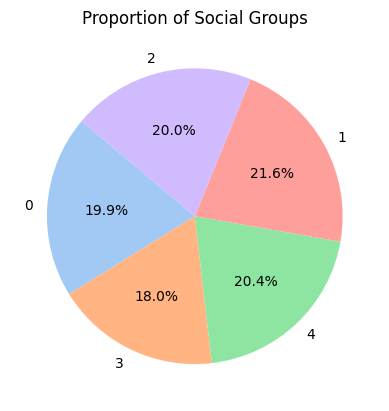

In [358]:
social_groups = [p['social_group'] for p in population]
group_counts = Counter(social_groups)

plt.pie(group_counts.values(), labels=group_counts.keys(), autopct='%1.1f%%', startangle=140, colors=sns.color_palette("pastel"))
plt.title("Proportion of Social Groups")
plt.show()

1. **Stubbornness Index: 0.2**  
   - A stubbornness index of 0.2 indicates that the population is relatively inflexible in changing their preferences during interactions. The closer the index is to 1, the more stubborn the population is. This value shows some resistance to change but also some flexibility.

2. **Initial Statistics:**
   - **Mean = 0.0312:** The initial population has a slight overall bias towards positive preferences. However, this value is very close to 0, indicating an almost even distribution between negative and positive preferences.
   - **Std Dev = 0.8643:** The initial standard deviation is relatively high, showing significant variability in the population's preferences at the start.

3. **Final Statistics:**
   - **Mean = -0.0019:** After 400 interactions, the population's average preference has almost completely neutralized, leaning slightly negative. This suggests that interactions may have balanced out initial biases.
   - **Std Dev = 0.0106:** The final standard deviation is much smaller compared to the initial value, indicating that the population's preferences have converged significantly. This reduced variability suggests stronger consensus or influence within the population.